## Import and dependencies

Pip

In [ ]:
!pip install kagglehub

Import

In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

Method() definition

In [ ]:
import numpy as np
import pandas as pd

def remove_outliers_mahalanobis(df, column, threshold=3.0):

    df_clean = df.copy()

    mean_val = df_clean[column].mean()
    var_val = df_clean[column].var()

    distances = np.abs(df_clean[column] - mean_val) / np.sqrt(var_val)

    mask = distances <= threshold
    df_filtered = df_clean[mask]

    return df_filtered

Data load

In [ ]:
path = kagglehub.dataset_download("sidharth178/car-prices-dataset")
print(path)
data = pd.read_csv(path + '/train.csv')
data.head(5)

/root/.cache/kagglehub/datasets/sidharth178/car-prices-dataset/versions/1


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## Data exploration

In [ ]:
data.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

Focus on price

In [ ]:
print("Min: ",data['Price'].min())
print("Max: ",data['Price'].max())
print("Mean: ",data['Price'].mean())

Min:  1
Max:  26307500
Mean:  18555.92722357956


In [ ]:
low_price_data = data.loc[data['Price'] <= 1].head()
display(low_price_data)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
7815,45765530,1,-,OPEL,Astra,1999,Sedan,Yes,Petrol,1.6,122231 km,4.0,Manual,Front,04-May,Left wheel,Silver,4
16992,45772201,1,1202,CHEVROLET,Lacetti,2006,Hatchback,No,Petrol,1.6,200000 km,4.0,Manual,Front,04-May,Left wheel,Black,2


(array([271., 157., 225., 149., 333., 249.,   5., 276., 181., 199., 171.,
        106.,   2., 122., 128.,  94.,  43.,  37.,   2.,  31.,  37.,  35.,
         47.,  70.,   1.,  54.,  63.,  33.,  58.,  23.]),
 array([1.0000e+00, 6.6300e+01, 1.3160e+02, 1.9690e+02, 2.6220e+02,
        3.2750e+02, 3.9280e+02, 4.5810e+02, 5.2340e+02, 5.8870e+02,
        6.5400e+02, 7.1930e+02, 7.8460e+02, 8.4990e+02, 9.1520e+02,
        9.8050e+02, 1.0458e+03, 1.1111e+03, 1.1764e+03, 1.2417e+03,
        1.3070e+03, 1.3723e+03, 1.4376e+03, 1.5029e+03, 1.5682e+03,
        1.6335e+03, 1.6988e+03, 1.7641e+03, 1.8294e+03, 1.8947e+03,
        1.9600e+03]),
 <BarContainer object of 30 artists>)

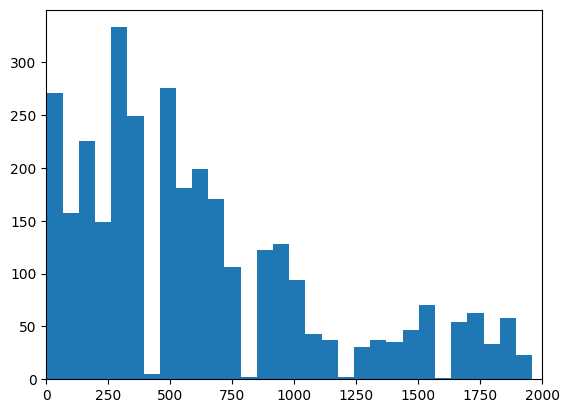

In [ ]:
## distribution of prices :
plt.xlim(0, 2000)
plt.hist(data['Price'][data['Price'] < 2000], bins=30)

We identify 5 different price range so our first objective will probably be to cluster Prices with a differentiating variable

In [ ]:
# Explorigin if price is hygly correlated to manufacturer :
price_manufacturer = data.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False)
display(price_manufacturer)

,Price
Manufacturer,
LAMBORGHINI,872946.000000
BENTLEY,197574.500000
OPEL,73305.617128
FERRARI,66955.500000
LAND ROVER,54053.489796
...,...
VAZ,4613.583333
MOSKVICH,4609.000000
ZAZ,3822.500000


In [ ]:
for manufacturer in price_manufacturer.index:
  print(f"{manufacturer}: {round(data.loc[data['Manufacturer'] == manufacturer]['Price'].mean())}")

LAMBORGHINI: 872946
BENTLEY: 197574
OPEL: 73306
FERRARI: 66956
LAND ROVER: 54053
ASTON MARTIN: 54000
TESLA: 53941
PORSCHE: 47106
JAGUAR: 34409
HUMMER: 31211
SSANGYONG: 30895
JEEP: 25409
HYUNDAI: 22338
BMW: 20877
MASERATI: 20150
INFINITI: 19775
LEXUS: 19191
MERCEDES-BENZ: 18609
სხვა: 17248
MINI: 17136
SCION: 16173
FORD: 15574
KIA: 15251
SKODA: 15080
HAVAL: 15053
CHEVROLET: 14926
HONDA: 14291
TOYOTA: 14249
AUDI: 14107
SATURN: 13799
LINCOLN: 13652
CADILLAC: 13514
PEUGEOT: 13470
MITSUBISHI: 13147
MERCURY: 12544
LANCIA: 12231
SUZUKI: 11833
VOLKSWAGEN: 11640
RENAULT: 11464
FIAT: 11186
BUICK: 11074
CITROEN: 10640
GAZ: 10482
VOLVO: 10279
GREATWALL: 10036
NISSAN: 10032
SUBARU: 9999
ALFA ROMEO: 9890
ISUZU: 9644
MAZDA: 9533
CHRYSLER: 8632
DODGE: 8458
DAEWOO: 6973
SAAB: 6920
GMC: 6831
PONTIAC: 6600
ACURA: 5911
DAIHATSU: 5403
UAZ: 5291
SEAT: 4830
VAZ: 4614
MOSKVICH: 4609
ZAZ: 3822
ROVER: 2433
ROLLS-ROYCE: 178


In [ ]:
## If we look at all rolls-royce line for instance
rolls_royce = data.loc[data['Manufacturer'] == 'ROLLS-ROYCE']
display(rolls_royce)

## We lack too much informations and our data is really unbalanced. We can't yield any informations from thhis columns

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
10265,26556126,157,-,ROLLS-ROYCE,Phantom,1939,Cabriolet,Yes,Petrol,5,129000 km,8.0,Automatic,Rear,04-May,Left wheel,Silver,0
15613,41720592,200,-,ROLLS-ROYCE,Phantom,1939,Limousine,Yes,Petrol,2.2,169000 km,4.0,Manual,Rear,04-May,Left wheel,White,0


In [ ]:
## We will need to delete outliers

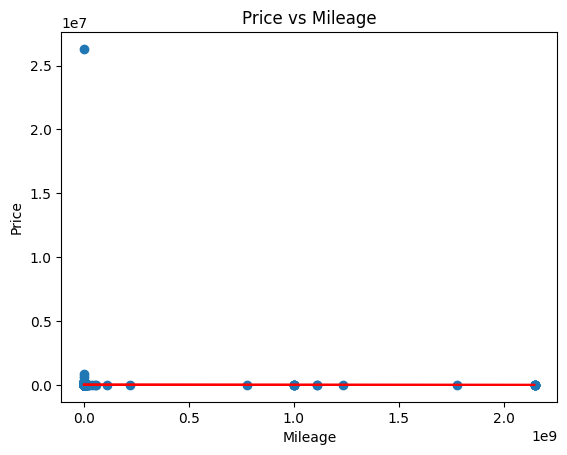

In [ ]:
## Exploring correlation between price and Mileage using LinearRegression()

## Keeping only the float part of the feature
data['Mileage'] = data['Mileage'].str.replace(' km', '')
data['Mileage'] = data['Mileage'].astype(float)


X = data['Mileage'].values.reshape(-1, 1)
y = data['Price']

model = LinearRegression()
model.fit(X, y)

plt.scatter(X, y)
plt.plot(X, model.predict(X), color='red')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Price vs Mileage')
plt.show()

We clearly have outliers

In [ ]:
## Removing Price outliers using Mahalanobis distance:
filtered_data = remove_outliers_mahalanobis(data, 'Price')

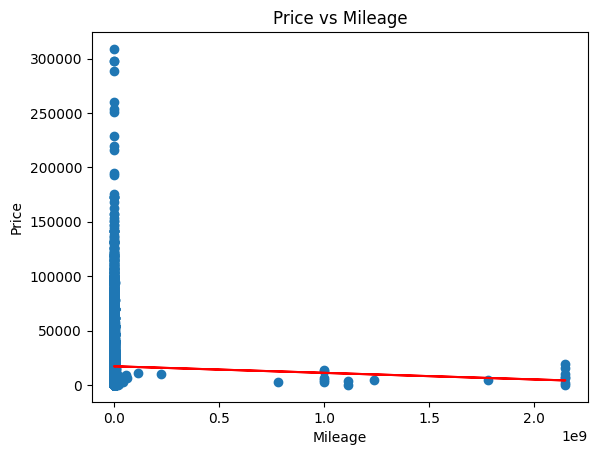

In [ ]:
## Exploring correlation between price and Mileage using LinearRegression()

## Keeping only the float part of the feature
filtered_data['Mileage'] = filtered_data['Mileage']
filtered_data['Mileage'] = filtered_data['Mileage'].astype(float)


X = filtered_data['Mileage'].values.reshape(-1, 1)
y = filtered_data['Price']

model = LinearRegression()
model.fit(X, y)

plt.scatter(X, y)
plt.plot(X, model.predict(X), color='red')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Price vs Mileage')
plt.show()

In [ ]:
for manufacturer in filtered_data['Manufacturer'].unique():
  print(f"{manufacturer}: {round(filtered_data.loc[filtered_data['Manufacturer'] == manufacturer]['Price'].mean())}")
  print(f"Count: {filtered_data['Manufacturer'].value_counts()[manufacturer]}")

LEXUS: 19191
Count: 982
CHEVROLET: 14926
Count: 1069
HONDA: 14291
Count: 977
FORD: 15574
Count: 1111
HYUNDAI: 22338
Count: 3769
TOYOTA: 14249
Count: 3662
MERCEDES-BENZ: 18316
Count: 2075
OPEL: 7058
Count: 396
PORSCHE: 47106
Count: 54
BMW: 20877
Count: 1049
JEEP: 25409
Count: 138
VOLKSWAGEN: 11640
Count: 579
AUDI: 14107
Count: 255
RENAULT: 11464
Count: 37
NISSAN: 10032
Count: 660
SUBARU: 9999
Count: 275
DAEWOO: 6973
Count: 91
KIA: 15251
Count: 421
MITSUBISHI: 13147
Count: 289
SSANGYONG: 30895
Count: 441
MAZDA: 9533
Count: 183
GMC: 6831
Count: 15
FIAT: 11186
Count: 78
INFINITI: 19775
Count: 30
ALFA ROMEO: 9890
Count: 4
SUZUKI: 11833
Count: 76
ACURA: 5911
Count: 15
LINCOLN: 13652
Count: 15
VAZ: 4614
Count: 48
GAZ: 10482
Count: 12
CITROEN: 10640
Count: 9
LAND ROVER: 54053
Count: 49
MINI: 17136
Count: 48
DODGE: 8458
Count: 91
CHRYSLER: 8632
Count: 26
JAGUAR: 34409
Count: 42
ISUZU: 9644
Count: 4
SKODA: 15080
Count: 20
DAIHATSU: 5403
Count: 13
BUICK: 11074
Count: 16
TESLA: 53941
Count: 1
CADI

In [ ]:
## Imputing na values :
data = filtered_data
for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

<ipython-input-18-c48ce9bd837d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-18-c48ce9bd837d>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
data.describe()

,ID,Price,Prod. year,Mileage,Cylinders,Airbags
count,1.923400e+04,19234.000000,19234.000000,1.923400e+04,19234.000000,19234.000000
mean,4.557650e+07,17113.065717,2010.912551,1.532469e+06,4.582666,6.583030
std,9.366606e+05,18278.647663,5.667786,4.840764e+07,1.199513,4.319807
min,2.074688e+07,1.000000,1939.000000,0.000000e+00,1.000000,0.000000
25%,4.569836e+07,5331.000000,2009.000000,7.015675e+04,4.000000,4.000000
50%,4.577231e+07,13172.000000,2012.000000,1.260090e+05,4.000000,6.000000
75%,4.580204e+07,22063.000000,2015.000000,1.889720e+05,4.000000,12.000000
max,4.581665e+07,308906.000000,2020.000000,2.147484e+09,16.000000,16.000000


In [ ]:
## First attempts at our modelisation with what we learnt
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

data = pd.read_csv(path + '/train.csv')

data['Mileage'] = data['Mileage'].str.replace(' km', '')
data['Mileage'] = data['Mileage'].astype(float)


features = ['Prod. year','Mileage','Cylinders','Airbags']

## Removing outliers :
# Remove outliers from Price column only
filtered_data = remove_outliers_mahalanobis(data, 'Price', threshold=3.0)
filtered_data = filtered_data[features + ['Price']].replace([np.inf, -np.inf], np.nan).dropna()

data1 = filtered_data.copy()

X = add_constant(data1[features])
y = data1['Price']
model = OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     614.1
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:36:09   Log-Likelihood:            -2.1489e+05
No. Observations:               19234   AIC:                         4.298e+05
Df Residuals:                   19229   BIC:                         4.298e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.14e+06   4.59e+04    -46.580      0.0

In [ ]:
## Now we add the fuel type dummies in our model to see if it increases our R-squared
data = pd.read_csv(path + '/train.csv')

data['Mileage'] = data['Mileage'].str.replace(' km', '')
data['Mileage'] = data['Mileage'].astype(float)

features = ['Prod. year','Mileage','Cylinders','Airbags','Fuel type']

## Removing outliers :
# Remove outliers from Price column only
filtered_data = remove_outliers_mahalanobis(data, 'Price', threshold=3.0)
filtered_data = filtered_data[features + ['Price']].replace([np.inf, -np.inf], np.nan).dropna()

## Adding dumies on fuel_type :
print(filtered_data['Fuel type'].unique())
data1 = pd.get_dummies(filtered_data, columns=['Fuel type'],prefix='Fuel')
for col in data1.columns:
    data1[col] = data1[col].astype(int)

features = ['Prod. year','Mileage','Cylinders','Airbags']
features = features + list(data1.columns[data1.columns.str.startswith('Fuel')])
## Turning all true and false

X = add_constant(data1[features])
y = data1['Price']
model = OLS(y, X).fit()
print(model.summary())

['Hybrid' 'Petrol' 'Diesel' 'CNG' 'Plug-in Hybrid' 'LPG' 'Hydrogen']
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     387.0
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:36:10   Log-Likelihood:            -2.1428e+05
No. Observations:               19234   AIC:                         4.286e+05
Df Residuals:                   19223   BIC:                         4.287e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

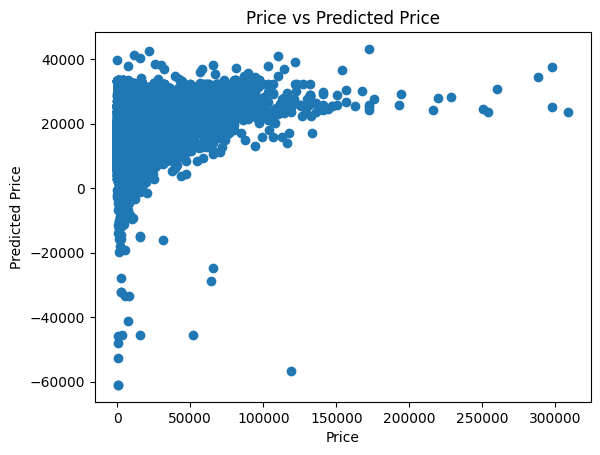

In [ ]:
## plotting price vs prediction :
y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.title('Price vs Predicted Price')
plt.show()

In [ ]:
## Our model still have a tendency to predict higher values:

In [ ]:
## Using PCA on our features to extract variance :
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Explained Variance Ratio: [0.15479108 0.13957867 0.11402048 0.10487935 0.09317341 0.09185134
 0.09072712 0.0888781  0.06911908 0.05298137]
Number of Components: 10


In [ ]:
y = data1['Price']
X = sm.add_constant(data1.drop('Price', axis=1))
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     387.0
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:36:22   Log-Likelihood:            -2.1428e+05
No. Observations:               19234   AIC:                         4.286e+05
Df Residuals:                   19223   BIC:                         4.287e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.711e+04    120.279    142.278      0.0

In [ ]:
## We now have the set of features:
## Train test split :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

RF

In [ ]:
## Regression forest training :
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
## Testing on test set :
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

Root Mean Squared Error: 13268.066561095988


XGBoost

In [ ]:
## XgBoost_training :
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
## Testing on test set :
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

Root Mean Squared Error: 13103.31622147615


Hyperparam tuning :

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Run the grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best cross-validation score (converted to RMSE)
print("Best parameters found:", grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))

# Evaluate the best estimator on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best CV RMSE: 14243.712100432247
Test RMSE: 13787.726135951498


In [ ]:
from keras import layers, Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-10,restore_best_weight = True),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)

Epoch 1/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 577731392.0000 - val_loss: 455577824.0000 - learning_rate: 0.0010
Epoch 2/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 364157600.0000 - val_loss: 362433440.0000 - learning_rate: 0.0010
Epoch 3/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 305276736.0000 - val_loss: 364446720.0000 - learning_rate: 0.0010
Epoch 4/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 301350720.0000 - val_loss: 364812896.0000 - learning_rate: 0.0010
Epoch 5/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 323048992.0000 - val_loss: 363887264.0000 - learning_rate: 0.0010
Epoch 6/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 315689824.0000 - val_loss: 363908000.0000 - learning_rate: 0.0010
Epoch 7/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 301429888.0000 - val_loss: 362627712.0000 - learning_rate: 0.0010
Epoch 8/10000
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 321348096.0000 - val_loss: 368449

In [ ]:
## Testing on test set :
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Root Mean Squared Error: 16394.21458929948


So XGBoost is better than our simple Deep Learning model !

In [ ]:
## Recreating XGBoost for export knowing that : 'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8
## XgBoost_training :
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,learning_rate = 0.2,max_depth = 5,n_estimators=50,subsample=0.8,colsample_bytree=1.0)
xgb_model.fit(X_train, y_train)
## Testing on test set :
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

Root Mean Squared Error: 13097.753089747875


In [ ]:
## Saving model in Pickle
import pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
## Downloading using google.colab download
from google.colab import files
files.download('xgb_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## how to use the model

In [ ]:
X.head(5)

,Prod. year,Mileage,Cylinders,Airbags,Fuel_CNG,Fuel_Diesel,Fuel_Hybrid,Fuel_Hydrogen,Fuel_LPG,Fuel_Petrol,Fuel_Plug-in Hybrid
0,2010,186005,6,12,0,0,1,0,0,0,0
1,2011,192000,6,8,0,0,0,0,0,1,0
2,2006,200000,4,2,0,0,0,0,0,1,0
3,2011,168966,4,0,0,0,1,0,0,0,0
4,2014,91901,4,4,0,0,0,0,0,1,0


In [ ]:
X_train.iloc[0]

,13217
Prod. year,2013
Mileage,88000
Cylinders,4
Airbags,6
Fuel_CNG,0
Fuel_Diesel,0
Fuel_Hybrid,0
Fuel_Hydrogen,0
Fuel_LPG,0
Fuel_Petrol,1
